In [114]:
import pandas as pd, numpy as np
import os
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse
from ResearchML import *
from mlfinlab.microstructural_features import *
from mlfinlab.sample_weights import *
from sklearn.ensemble import RandomForestClassifier

workPath = "/home/xetra/AlphaGoldmine/Data/"
future = "CL"
y = 2018

contFuture = os.path.join(workPath, future.lower(), f"{future}Cont")
contFutureMLOLD = os.path.join(workPath, future.lower(), f"{future}ContML")

vbPath = os.path.join(workPath, future.lower(), f"{future}ContVB")
contFutureLevelBucketsVB = os.path.join(workPath,future.lower(), f"{future}ContLevelBuckets")
vpDir = os.path.join(workPath,future.lower(),"VP")

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100



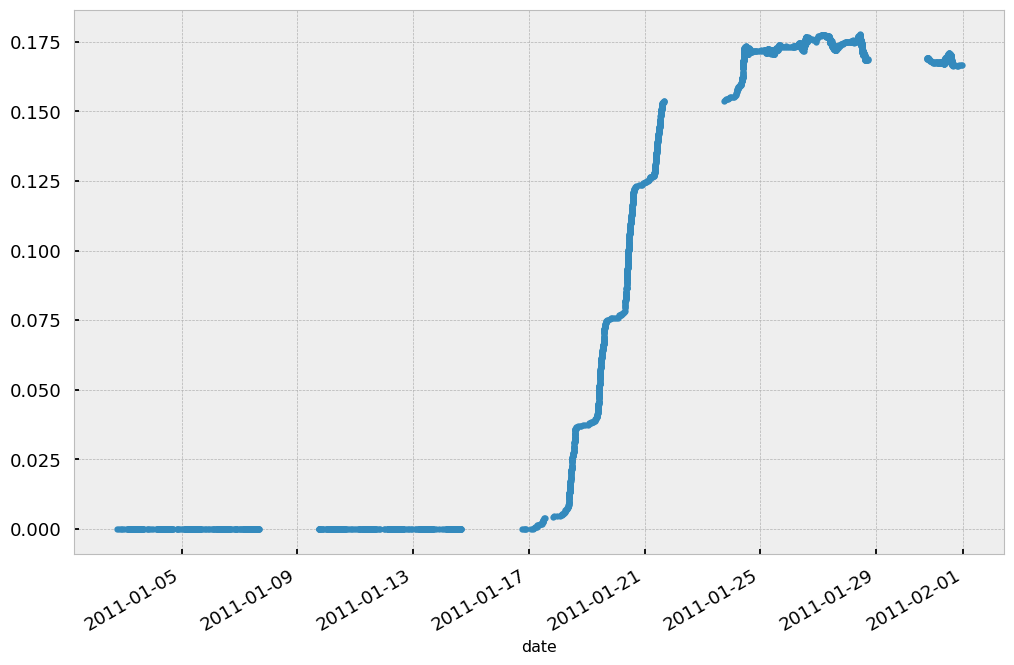

In [88]:
df = pd.read_feather(contFuture).set_index("date")
vb = pd.read_feather(vbPath).set_index("date")
vb.loc[(vb.index.year==2011)&(vb.index.month==1),"VPIN"].plot(style=".")
vb = vb.loc[vb.index.date>=parse("2011-01-25").date()] #cut out bad data due to missing volume

In [89]:
dfMl = pd.read_feather(contFutureLevelBucketsVB).set_index("date")
dfOld = pd.read_feather(contFutureMLOLD).set_index("date")

In [90]:
cols = ["relCVD","OFI",'ttFomc','ttInv','teaCVbCUSUM','teaVToPCUSUM','ttUsOpen','ttEuOpen','ttUsClose','teaFomc', 'teaInv']
buckets = [c for c in dfMl.columns if c.endswith("B")]
vb.loc[vb.index,buckets] = dfMl.loc[dfMl.index.intersection(vb.index),buckets]
vb.loc[vb.index,cols] = dfMl.loc[dfMl.index.intersection(vb.index),cols]
vb["teaInv"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.inv==1].index,y=-.7)
vb["teaFomc"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.fomc==1].index,y=-.7)
vb["teaCVbCUSUM"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.cVbCUSUM==1].index,y=-.7)
vb["teaVToPCUSUM"] = timeElapsedAfterEventVectorized(dfOld.index,dfOld[dfOld.vToPCUSUM==1].index,y=-.7)

In [91]:
vb = vb.drop("teaVToPCUSUM",1)

In [92]:
vb = vb.drop("VPIN",1)

In [93]:
vb.columns

Index(['oVb', 'hVb', 'lVb', 'cVb', 'volVb', 'nrTVb', 'bidVolVb', 'askVolVb',
       'asiaSesHB', 'asiaSesLB', 'euSesHB', 'euSesLB', 'usSesHB', 'usSesLB',
       'o1DB', 'h1DB', 'l1DB', 'c1DB', 'retrDB', 'o1WB', 'h1WB', 'l1WB',
       'c1WB', 'retrWB', 'o1MB', 'h1MB', 'l1MB', 'c1MB', 'retrMB', 'valB',
       'vahB', 'pocB', 'relCVD', 'OFI', 'ttFomc', 'ttInv', 'teaCVbCUSUM',
       'ttUsOpen', 'ttEuOpen', 'ttUsClose', 'teaFomc', 'teaInv'],
      dtype='object')

In [94]:
vb["rPrices"] = df.loc[vb.index,"rPrices"]

In [95]:
window=500

In [96]:
vb["RollImpact"] = get_roll_impact(vb.cVb,vb.cVb*vb.volVb,window=window)

In [97]:
vb["SpreadEst"] = get_corwin_schultz_estimator(vb.hVb,vb.lVb,window=window)

In [98]:
vb["vola"] = get_bekker_parkinson_vol(vb.hVb,vb.lVb,window=window)

In [99]:
vb["KylesLambda"] = get_bar_based_kyle_lambda(vb.cVb,vb.volVb,window=window)

In [100]:
vb["AmihudLambda"] = get_bar_based_amihud_lambda(vb.cVb,vb.cVb*vb.volVb,window=window)

In [101]:
vb["hasbroukLambda"] = get_bar_based_hasbrouck_lambda(vb.cVb,vb.cVb*vb.volVb,window=window)

In [102]:
vb["VPIN"] = get_vpin(vb.cVb, vb.askVolVb,window=window)

In [103]:
colsToDrop = [
    "oVb",
    "hVb",
    "lVb",
    "volVb",
    "nrTVb",
    "bidVolVb",
    "askVolVb",
]

In [104]:
vb = vb.drop(colsToDrop,1)

In [105]:
# Prep for ML for window=500

In [106]:
span=100

In [107]:
import os


In [108]:
eventsPath=f"events-vol{span}-window{window}"
trgt = getDailyVol(vb.cVb,span0=span)
# t1 = getT1(df["c"],vb.index,span=pd.Timedelta(hours=8))
if os.path.exists(eventsPath): events=pd.read_feather(eventsPath).set_index("date")
else: 
    events=getEvents(close=df["c"],tEvents=vb.index,ptSl=[1],trgt=trgt,minRet=trgt.quantile(0.25),numThreads=10)#,t1=t1)
    events.reset_index().to_feather(eventsPath)
out = getBins(events=events,close=df["c"])
# out = out[out.bin != 0]
# events = events.loc[out.index]

In [109]:
out.bin.value_counts()

-1.0    227829
 1.0    220700
Name: bin, dtype: int64

In [110]:
### Overlapping Labels

In [111]:
# numCoEvents=mpPandasObj(mpNumCoEvents,("molecule",events.index),numThreads=12,closeIdx=vb.index,t1=events["t1"])
# numCoEvents=numCoEvents.loc[~numCoEvents.index.duplicated(keep="last")]
# numCoEvents=numCoEvents.reindex(vb.index).fillna(0)
# out["tW"]=mpPandasObj(mpSampleTW,("molecule",events.index),numThreads=12,t1=events["t1"],numCoEvents=numCoEvents)
# out["w"]=mpPandasObj(mpSampleW,("molecule",events.index),numThreads=12,t1=events["t1"],numCoEvents=numCoEvents,close=df.c)

In [115]:
w = get_weights_by_return(events.dropna(),vb.cVb,12)

2021-03-18 21:08:38.445228 100.0% num_concurrent_events done after 0.72 minutes. Remaining 0.0 minutes.
2021-03-18 21:09:22.829802 100.0% _apply_weight_by_return done after 0.73 minutes. Remaining 0.0 minutes.


<AxesSubplot:>

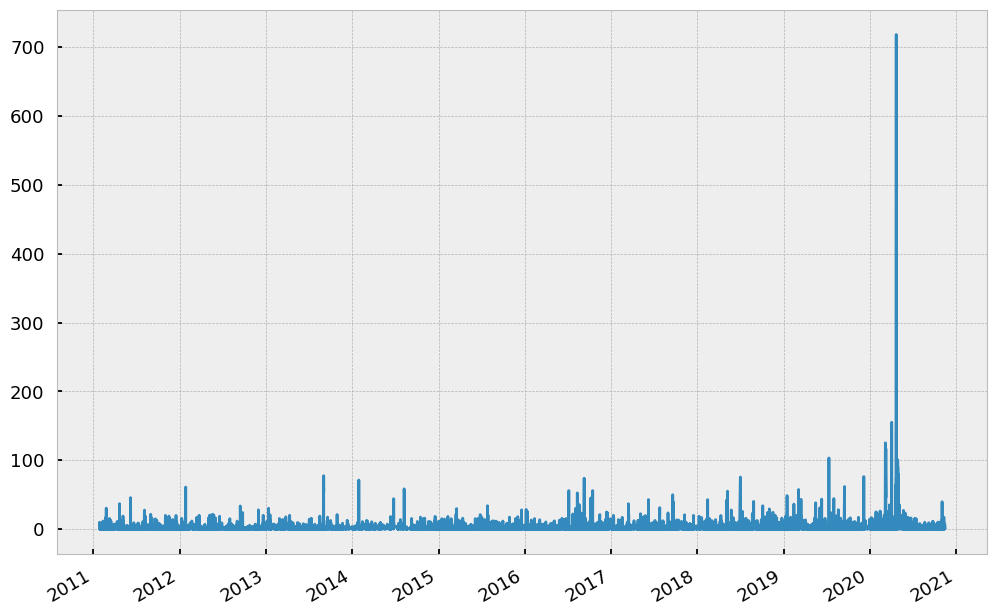

In [116]:
w.plot()

In [117]:
# clf0 = DecisionTreeClassifier(criterion="entropy",max_features="auto",class_weight="balanced")
clf0 = RandomForestClassifier(n_estimators=1,criterion="entropy",bootstrap=False,class_weight="balanced_subsample")
# clf0 = BaggingClassifier(base_estimator=clf1,n_estimators=1000,max_samples=avgU.mean(),n_jobs=-1)

In [118]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, log_loss

In [119]:
clf2 = RandomForestClassifier(n_estimators=1,criterion="entropy",bootstrap=False,class_weight="balanced_subsample")
clf2 = BaggingClassifier(base_estimator=clf2,n_estimators=1000,max_samples=0.5,max_features=1.,oob_score=False,n_jobs=-1)

In [32]:
X = vb.loc[vb.index.year<2019].drop("cVb",1).mul(w.loc[w.index.year<2019],0)
y = out.loc[out.index.year<2019,"bin"]

In [33]:
idx=X.dropna().index

In [34]:
clf2.fit(X.loc[idx],y.loc[idx])

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                        class_weight='balanced_subsample',
                                                        criterion='entropy',
                                                        n_estimators=1),
                  max_samples=0.5, n_estimators=1000, n_jobs=-1)

In [35]:
cv_gen = PurgedKFold(n_splits=5, samples_info_sets=events.loc[idx,"t1"], pct_embargo=0.2)
# scores_array = ml_cross_val_score(clf2,X.loc[idx],y.loc[idx],cv_gen,sample_weight_train=w.loc[idx],scoring=log_loss)
cv_gen

PurgedKFold(n_splits=5, pct_embargo=0.2,
      samples_info_sets=2011-01-27 08:40:00   2011-01-27 11:04:00
2011-01-27 08:41:00   2011-01-27 11:07:00
2011-01-27 08:43:00   2011-01-27 11:06:00
2011-01-27 08:46:00   2011-01-27 11:07:00
2011-01-27 08:52:00   2011-01-27 11:04:00
                              ...
2018-12-31 15:11:00   2019-01-...1 20:48:00
2018-12-31 16:48:00   2019-01-01 20:47:00
Name: t1, Length: 327825, dtype: datetime64[ns])

In [36]:
# scores_array

## Feature Importance Analyzis

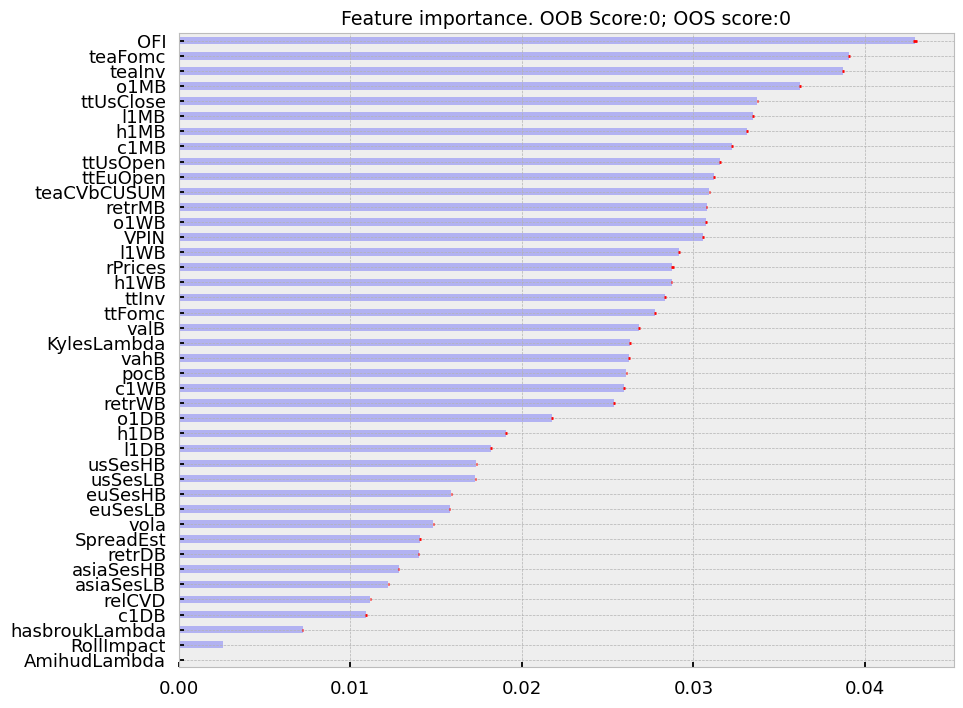

In [36]:
mdi=mean_decrease_impurity(clf2,X.columns)
plot_feature_importance(mdi,
oob_score=0,
oos_score=0,
oos_score=,
)

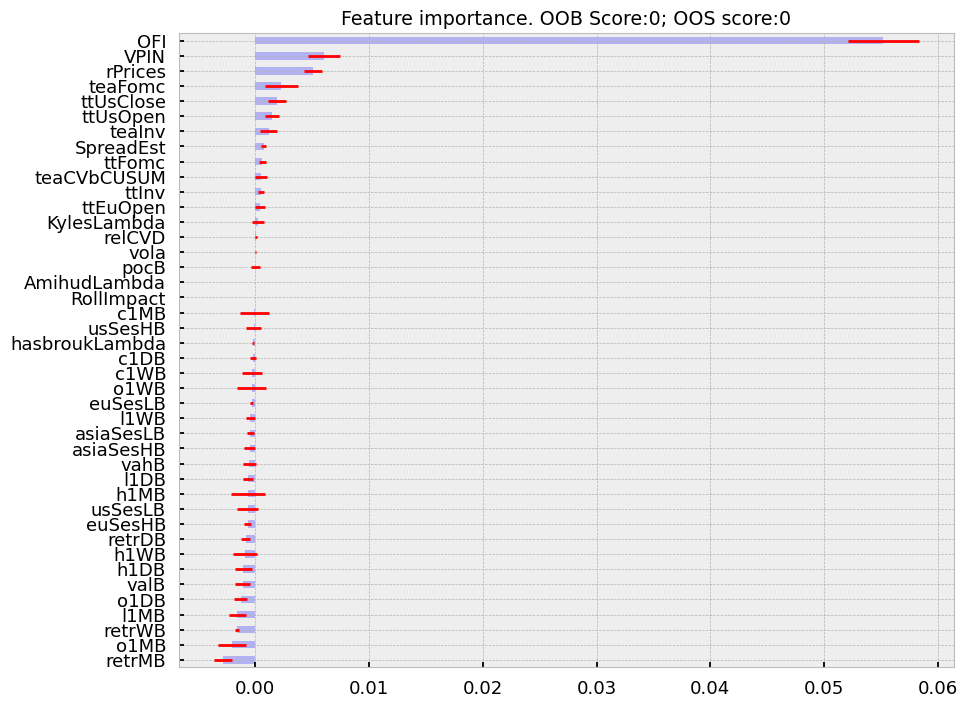

In [37]:
mda=mean_decrease_accuracy(clf2,X.loc[idx],y.loc[idx],cv_gen,sample_weight_train=w.loc[idx],scoring=log_loss)
plot_feature_importance(mda,
oob_score=0,
oos_score=0,
)

In [50]:
sfi = single_feature_importance(clf2,X.loc[idx],y.loc[idx],cv_gen,sample_weight_train=w.loc[idx],scoring=log_loss)
plot_feature_importance(sfi,
oob_score=0,
oos_score=0,
)

/home/xetra/miniconda3/envs/ml/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
